In [12]:
import pandas as pd
import numpy as np
from scipy import stats

import matplotlib.pyplot as plt
import seaborn as sns

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import LabelEncoder
from sklearn import linear_model
from sklearn.metrics import classification_report

from scripts.functions import get_dataset
from scripts.functions import add_zipcode
from scripts.functions import add_province
from scripts.functions import set_feat_target

import sys
# Ensure that import from parent directory is correctly implemented
sys.path.append('..')
from scripts.colors import bcolors as bc

## Modeling 
- Load datas
- Add zipcode from csv, based on locality column
- Add Provinces based on zipcode

In [13]:
# Load the datas 
file = '../datas/Immoweb_data_ok_maite.csv'
data = get_dataset(file)
# Add zipcode column
zip_path = "../datas/Postal_codes.csv"
data = add_zipcode(zip_path, data)
# Add Province column
data = add_province(data)

- Slice df for modeling
- Split feature, target
- Split train, test
- Normalize or standardise

In [31]:
# Select columns for modeling
data_model_house = data[data['House or appartment?'] == 'HOUSE'][['Price', 'Province', 'Living area','Number of rooms']]
# Get dummies for Province columns
data_model_house = pd.get_dummies(data_model_house, columns =['Province'],drop_first=True )
# Split features, target
X, y = set_feat_target(data_model_house)
# Split into train, test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state= 41)
# Standardisation
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

### Linear Regression
- Instanciate linear regression
- Fit the model and get score
- Test the model and get score


In [32]:
# Model instanciation
regressor = linear_model.LinearRegression()

# Train the model
regressor.fit(X_train, y_train)
accuracy_train = round(regressor.score(X_train, y_train)*100,2)
print(f"Linear {bc.OKBLUE}train{bc.ENDC} score : {bc.OKGREEN if accuracy_train > 60 else bc.WARNING if accuracy_train > 50 else bc.FAIL}{accuracy_train}{bc.ENDC} %")

# Test the model
accuracy_test = round(regressor.score(X_test, y_test)*100, 2)
print(f"Linear {bc.OKBLUE}test{bc.ENDC} score : {bc.OKGREEN if accuracy_test > 60 else bc.WARNING if accuracy_test > 50 else bc.FAIL}{accuracy_test}{bc.ENDC} %")

# Prediction
pred_test = regressor.predict(X_test)

Linear train score : 53.46 %
Linear test score : 44.49 %


### Plot results

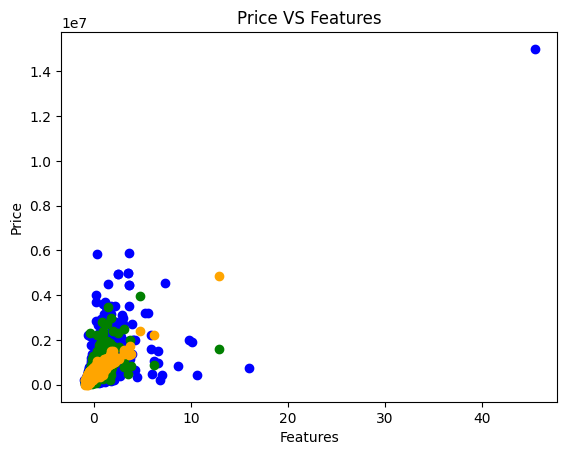

In [33]:
# Plot the predicted values against the input values
plt.scatter(X_train[:,0], y_train, color='blue')
# plt.plot(X_train, pred_train, color='red')
plt.scatter(X_test[:,0], y_test, color='green')
plt.scatter(X_test[:,0], pred_test, color='orange')

# Label the plot
plt.title("Price VS Features")
plt.xlabel('Features')
plt.ylabel('Price')

# Show the plot
plt.show()
plt.close()